## # Imports & Constants
Necessary libraries are imported and the diffusion steps (T) are defined.

In [23]:
import json
import os
import random
import matplotlib.pyplot as plt

import ndjson
import numpy as np
import torch
import torch.nn as nn
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import os
import random
import numpy as np
import torch
T=200



## # Data Loading & Conversion
Sketch data from the QuickDraw dataset is loaded and converted into tensor format.

In [7]:
def normalize_strokes(strokes, image_size=256, padding=10):
    all_x = [pt for x, _ in strokes for pt in x]
    all_y = [pt for _, y in strokes for pt in y]

    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)

    range_x = max_x - min_x
    range_y = max_y - min_y

    scale = (image_size - 2 * padding) / max(range_x, range_y)

    norm_strokes = []
    for x, y in strokes:
        norm_x = [(xi - min_x) * scale + padding for xi in x]
        norm_y = [(yi - min_y) * scale + padding for yi in y]
        norm_strokes.append((norm_x, norm_y))

    return norm_strokes


def draw_strokes_image(strokes, image_size=256, stroke_width=3):
    img = Image.new("RGB", (image_size, image_size), color="white")
    draw = ImageDraw.Draw(img)

    for x, y in strokes:
        if len(x) < 2:
            continue
        points = list(zip(x, y))
        draw.line(points, fill="black", width=stroke_width)
    return img


def render_gif_pillow_pointwise(strokes, save_path="sketch.gif", image_size=256, padding=10, repeat_frame=2,
                                stroke_width=2, delay_ms=30):
    if not strokes:
        print("No strokes to render.")
        return

    norm_strokes = normalize_strokes(strokes, image_size=image_size, padding=padding)
    frames = []

    img = Image.new("RGB", (image_size, image_size), color="white")
    draw = ImageDraw.Draw(img)

    for x, y in norm_strokes:
        for i in range(1, len(x)):
            pt1 = (x[i - 1], y[i - 1])
            pt2 = (x[i], y[i])
            draw.line([pt1, pt2], fill="black", width=stroke_width)

            for _ in range(repeat_frame):
                frames.append(img.copy())

    # Save to GIF
    frames[0].save(
        save_path,
        save_all=True,
        append_images=frames[1:],
        optimize=False,
        duration=delay_ms,
        loop=0
    )
    print(f"GIF kaydedildi: {save_path}")


## # Funtions & Classes

In [8]:
# ======================= Data Loading =======================
def load_category_data(path):
    with open(path) as f:
        reader = ndjson.reader(f)
        return list(reader)


def load_indices(path):
    with open(path) as f:
        return json.load(f)


def convert_strokes(drawing):
    return [(x, y) for x, y in drawing['drawing']]


# ======================= Stroke Conversion =======================
def strokes_to_tensor(sketch, max_len=128):
    points = []
    prev_x, prev_y = 0, 0
    for stroke in sketch:
        x_list, y_list = stroke
        for i in range(len(x_list)):
            x, y = x_list[i], y_list[i]
            dx, dy = x - prev_x, y - prev_y
            prev_x, prev_y = x, y
            pen = 0 if i < len(x_list) - 1 else 1
            points.append([dx, dy, pen])
    points.append([0, 0, 2])
    if len(points) > max_len:
        points = points[:max_len]
    else:
        points += [[0, 0, 0]] * (max_len - len(points))
    return torch.tensor(points, dtype=torch.float32)


# ======================= Dataset =======================
class SketchDataset(Dataset):
    def __init__(self, sketch_list, max_len=128):
        self.sketches = sketch_list
        self.max_len = max_len

    def __len__(self):
        return len(self.sketches)

    def __getitem__(self, idx):
        sketch = convert_strokes(self.sketches[idx])
        return strokes_to_tensor(sketch, self.max_len)


# ======================= Diffusion Model =======================
class MiniDiffusionModel(nn.Module):
    def __init__(self, input_dim=3, cond_dim=3, hidden_dim=128, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim + cond_dim, hidden_dim, num_layers, batch_first=True)
        self.output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, cond):
        batch, seq_len, _ = x.shape
        cond = cond.unsqueeze(1).repeat(1, seq_len, 1)
        x = torch.cat([x, cond], dim=-1)
        out, _ = self.lstm(x)
        return self.output(out)


# ======================= Diffusion Scheduler =======================
# Güncel ve güvenli scheduler
def get_noise_schedule(T, beta_start=1e-4, beta_end=0.02):
    betas = torch.linspace(beta_start, beta_end, T)
    alphas = 1. - betas
    alpha_hat = torch.cumprod(alphas, dim=0)

    # 🔒 Burada güvenli clamp uyguluyoruz:
    eps = 1e-8
    alpha_hat = torch.clamp(alpha_hat, min=eps)
    return betas, alphas, alpha_hat


# ======================= Forward Step =======================
def q_sample(x_start, t, noise, alpha_hat):
    sqrt_alpha = alpha_hat[t].sqrt().unsqueeze(-1).unsqueeze(-1)
    sqrt_one_minus = (1 - alpha_hat[t]).sqrt().unsqueeze(-1).unsqueeze(-1)
    return sqrt_alpha * x_start + sqrt_one_minus * noise


# ======================= Training =======================
def train(model, dataset, class_id, epochs=10, batch_size=64, lr=1e-4, T=T):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    alpha_hat_tensor = alpha_hat.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch + 1}/{epochs}")

        for x in pbar:
            x = x.to(device)
            B = x.size(0)
            t = torch.randint(0, T, (B,), device=device).long()
            noise = torch.randn_like(x)
            x_noisy = q_sample(x, t, noise, alpha_hat_tensor)

            cond = torch.zeros(B, 3).to(device)
            cond[:, class_id] = 1.0

            pred_noise = model(x_noisy, cond)
            loss = loss_fn(pred_noise, noise)

            if torch.isnan(loss):
                print("❌ NaN oluştu, durduruluyor")
                break

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        print(f"Epoch {epoch + 1} Loss: {total_loss / len(loader):.4f}")




# ======================= Stroke Decode =======================
def tensor_to_strokes(tensor):
    x, y = 0, 0
    stroke, strokes = [], []
    for dx, dy, pen in tensor:
        x += dx
        y += dy
        stroke.append((x, y))
        if np.isnan(pen):
            continue  # veya break
        pen = int(round(pen.item()))
        if pen == 1:
            if stroke:
                strokes.append(list(zip(*stroke)))
            stroke = []
        elif pen == 2:
            if stroke:
                strokes.append(list(zip(*stroke)))
            break
    return strokes


def draw_sample(strokes):
    if not strokes:
        print("🌀 No strokes to draw.")
        return
    for x, y in strokes:
        plt.plot(x, y)
    plt.axis('equal')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.show()


def save_strokes_as_images(sketches, save_dir, prefix="img", image_size=256):
    import os
    os.makedirs(save_dir, exist_ok=True)
    for i, tensor in enumerate(sketches):
        strokes = tensor_to_strokes(tensor)
        if strokes:
            norm_strokes = normalize_strokes(strokes, image_size=image_size)  # ✅ normalize et
            img = draw_strokes_image(norm_strokes, image_size=image_size)  # 🎯 normalize
            img.save(os.path.join(save_dir, f"{prefix}_{i}.png"))



## # Model Definition
A conditional mini diffusion model based on LSTM is defined.

In [9]:
# Setup
betas, alphas, alpha_hat = get_noise_schedule(T)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## # Diffusion Scheduler & Noise Functions
Beta/alpha values for the diffusion process are defined.

In [10]:
# Load data
cat_data = load_category_data("../data/cat.ndjson")
cat_indices = load_indices("../data/subset/cat/indices.json")
cat_train = [cat_data[i] for i in cat_indices["train"]]
cat_dataset = SketchDataset(cat_train)

bus_data = load_category_data("../data/bus.ndjson")
bus_indices = load_indices("../data/subset/bus/indices.json")
bus_train = [bus_data[i] for i in bus_indices["train"]]
bus_dataset = SketchDataset(bus_train)

rabbit_data = load_category_data("../data/rabbit.ndjson")
rabbit_indices = load_indices("../data/subset/rabbit/indices.json")
rabbit_train = [rabbit_data[i] for i in rabbit_indices["train"]]
rabbit_dataset = SketchDataset(rabbit_train)

## # Training Function
The model is trained using MSE loss and the Adam optimizer.

In [11]:
# train
# EPOCH_NUMBER = 5
model_cat = MiniDiffusionModel()
# train(model_cat, cat_dataset, class_id=0, epochs=EPOCH_NUMBER, lr=1e-4, batch_size=64)
# torch.save(model_cat.state_dict(), "model_cat.pt")
#
model_bus = MiniDiffusionModel()
# train(model_bus, bus_dataset, class_id=1, epochs=EPOCH_NUMBER, lr=1e-4, batch_size=64)
# torch.save(model_bus.state_dict(), "model_bus.pt")
#
model_rabbit = MiniDiffusionModel()
# train(model_rabbit, rabbit_dataset, class_id=2, epochs=EPOCH_NUMBER, lr=1e-4, batch_size=64)
# torch.save(model_rabbit.state_dict(), "model_rabbit.pt")

## # Load Model Function

In [12]:
model_cat.load_state_dict(torch.load("model_cat.pt"))
model_bus.load_state_dict(torch.load("model_bus.pt"))
model_rabbit.load_state_dict(torch.load("model_rabbit.pt"))

<All keys matched successfully>

## # Stroke Decoding & Visualization
The sampled tensor is converted back to stroke format and drawn with matplotlib.

In [13]:
x = torch.randn(1, 128, 3).to(device)
class_label = torch.tensor([[1.0, 0, 0]], device=device)
out = model_cat(x, class_label)
print(out.mean().item(), out.std().item())  # 0.0 ve 0.0 geliyorsa öğrenmemiştir

-0.007733724545687437 0.9939199090003967


## # Setup
Scheduler values are initialized and the compute device is set.

In [27]:
SEED=1
@torch.no_grad()
def sample_sketch(model, class_id, seq_len=128, T=T, device='cpu', is_seed=True):
    model.eval()
    if is_seed:
        torch.manual_seed(seed=SEED)
    x = torch.randn(1, seq_len, 3).to(device)
    class_label = torch.zeros(1, 3).to(device)
    class_label[0, class_id] = 1

    for t in reversed(range(T)):
        pred_noise = model(x, class_label)

        # ✅ BURAYA EKLE
        if torch.isnan(pred_noise).any() or torch.isnan(x).any():
            print(f"🚨 NaN oluştu t={t}")
            return np.zeros((seq_len, 3))

        alpha = alphas[t].to(device)
        alpha_hat_t = alpha_hat[t].to(device)
        x0_pred = (x - (1 - alpha_hat_t).sqrt() * pred_noise) / alpha_hat_t.sqrt()

        if t > 0:
            noise = torch.randn_like(x)
            x = alpha.sqrt() * x0_pred + (1 - alpha).sqrt() * noise
        else:
            x = x0_pred

    return x.squeeze(0).cpu().numpy()


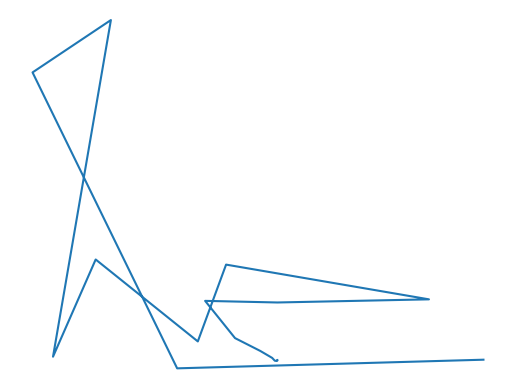

GIF kaydedildi: cat.gif


In [30]:
sample_cat = sample_sketch(model_cat, class_id=0, device=device)
strokes_cat = tensor_to_strokes(sample_cat)
if strokes_cat:
    draw_sample(strokes_cat)
    render_gif_pillow_pointwise(
        strokes_cat,
        save_path="cat.gif",
        repeat_frame=5,  # her segmenti 3 kare olarak göster
        delay_ms=20,  # 40 ms * 3 = 120 ms = yavaş yavaş
        stroke_width=2
    )
else:
    print(f"No strokes, retrying")

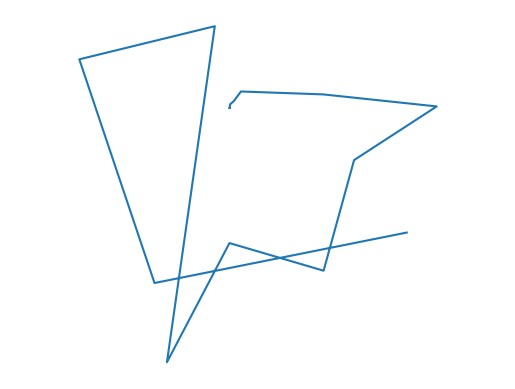

GIF kaydedildi: bus.gif


In [16]:
sample_bus = sample_sketch(model_bus, class_id=1, device=device)
strokes_bus = tensor_to_strokes(sample_bus)
if strokes_bus:
    draw_sample(strokes_bus)
    render_gif_pillow_pointwise(
        strokes_bus,
        save_path="bus.gif",
        repeat_frame=5,
        delay_ms=20,
        stroke_width=2
    )
else:
    print(f"No strokes, retrying")

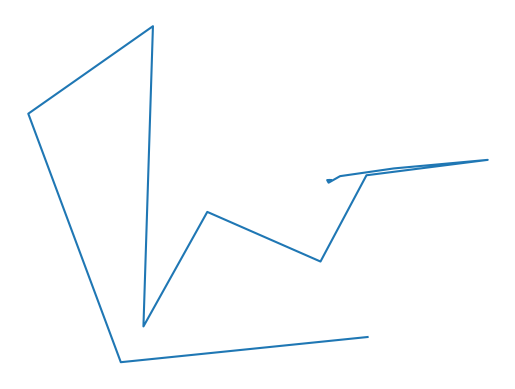

GIF kaydedildi: rabbit.gif


In [17]:
sample_rabbit = sample_sketch(model_rabbit, class_id=2, device=device)
strokes_rabbit = tensor_to_strokes(sample_rabbit)
if strokes_rabbit:
    draw_sample(strokes_rabbit)
    render_gif_pillow_pointwise(
        strokes_rabbit,
        save_path="rabbit.gif",
        repeat_frame=5,
        delay_ms=20,
        stroke_width=2
    )
else:
    print(f"No strokes, retrying")

In [18]:

from cleanfid import fid


def save_real_sketches_as_images(data, indices, save_dir, image_size=256, prefix="real"):
    os.makedirs(save_dir, exist_ok=True)
    for i, idx in enumerate(indices):
        sketch = convert_strokes(data[idx])
        norm_strokes = normalize_strokes(sketch, image_size=image_size)
        img = draw_strokes_image(norm_strokes, image_size=image_size)
        img.save(f"{save_dir}/{prefix}_{i}.png")


def save_fake_sketches_as_images(model, class_id, save_dir, device, image_size=256,
                                 max_needed=10, max_attempts=500, prefix="fake"):
    os.makedirs(save_dir, exist_ok=True)
    fake_count = 0
    attempts = 0
    while fake_count < max_needed and attempts < max_attempts:
        sample = sample_sketch(model, class_id=class_id, device=device, is_seed=False)
        strokes = tensor_to_strokes(sample)
        if strokes:
            norm_strokes = normalize_strokes(strokes, image_size=image_size)
            img = draw_strokes_image(norm_strokes, image_size=image_size)
            img.save(f"{save_dir}/{prefix}_{fake_count}.png")
            fake_count += 1
        else:
            print(f"⚠️ Boş çizim üretildi, atlanıyor ({attempts + 1})")
        attempts += 1
    print(f"✅ Toplam {fake_count} geçerli fake çizim üretildi.")


def compute_fid_kid(real_dir, fake_dir, label=""):
    fid_score = fid.compute_fid(real_dir, fake_dir, device="cpu")
    kid_score = fid.compute_kid(real_dir, fake_dir, device="cpu")
    print(f"FID ({label}):", fid_score)
    print(f"KID ({label}):", kid_score)
    return fid_score, kid_score





In [19]:
# CAT
save_real_sketches_as_images(cat_data, cat_indices["test"][:500], "real/cat")
save_fake_sketches_as_images(model_cat, max_needed=500, max_attempts=1000, class_id=0, save_dir="fake/cat",
                             device=device)
fid_cat, kid_cat = compute_fid_kid("real/cat", "fake/cat", label="cat")




⚠️ Boş çizim üretildi, atlanıyor (4)
⚠️ Boş çizim üretildi, atlanıyor (5)
⚠️ Boş çizim üretildi, atlanıyor (7)
⚠️ Boş çizim üretildi, atlanıyor (10)
⚠️ Boş çizim üretildi, atlanıyor (12)
⚠️ Boş çizim üretildi, atlanıyor (14)
⚠️ Boş çizim üretildi, atlanıyor (15)
⚠️ Boş çizim üretildi, atlanıyor (19)
⚠️ Boş çizim üretildi, atlanıyor (20)
⚠️ Boş çizim üretildi, atlanıyor (21)
⚠️ Boş çizim üretildi, atlanıyor (25)
⚠️ Boş çizim üretildi, atlanıyor (26)
⚠️ Boş çizim üretildi, atlanıyor (27)
⚠️ Boş çizim üretildi, atlanıyor (28)
⚠️ Boş çizim üretildi, atlanıyor (30)
⚠️ Boş çizim üretildi, atlanıyor (32)
⚠️ Boş çizim üretildi, atlanıyor (33)
⚠️ Boş çizim üretildi, atlanıyor (35)
⚠️ Boş çizim üretildi, atlanıyor (38)
⚠️ Boş çizim üretildi, atlanıyor (41)
⚠️ Boş çizim üretildi, atlanıyor (46)
⚠️ Boş çizim üretildi, atlanıyor (47)
⚠️ Boş çizim üretildi, atlanıyor (50)
⚠️ Boş çizim üretildi, atlanıyor (55)
⚠️ Boş çizim üretildi, atlanıyor (56)
⚠️ Boş çizim üretildi, atlanıyor (57)
⚠️ Boş çizim ür

/mnt/data/PYTHON_PROJECTS/myth_case/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Toplam 500 geçerli fake çizim üretildi.
compute FID between two folders
Found 500 images in the folder real/cat


FID cat : 100%|██████████| 16/16 [01:09<00:00,  4.36s/it]


Found 500 images in the folder fake/cat


FID cat : 100%|██████████| 16/16 [01:06<00:00,  4.18s/it]


compute KID between two folders
Found 500 images in the folder real/cat


KID cat : 100%|██████████| 16/16 [01:06<00:00,  4.16s/it]


Found 500 images in the folder fake/cat


KID cat : 100%|██████████| 16/16 [01:17<00:00,  4.82s/it]


FID (cat): 146.8122056109956
KID (cat): 0.1559542864561081


In [20]:
# BUS
save_real_sketches_as_images(bus_data, bus_indices["test"][:500], "real/bus")
save_fake_sketches_as_images(model_bus, max_needed=500, max_attempts=1000, class_id=1, save_dir="fake/bus",
                             device=device)
fid_bus, kid_bus = compute_fid_kid("real/bus", "fake/bus", label="bus")

⚠️ Boş çizim üretildi, atlanıyor (7)
⚠️ Boş çizim üretildi, atlanıyor (25)
⚠️ Boş çizim üretildi, atlanıyor (29)
⚠️ Boş çizim üretildi, atlanıyor (38)
⚠️ Boş çizim üretildi, atlanıyor (40)
⚠️ Boş çizim üretildi, atlanıyor (41)
⚠️ Boş çizim üretildi, atlanıyor (45)
⚠️ Boş çizim üretildi, atlanıyor (51)
⚠️ Boş çizim üretildi, atlanıyor (62)
⚠️ Boş çizim üretildi, atlanıyor (67)
⚠️ Boş çizim üretildi, atlanıyor (73)
⚠️ Boş çizim üretildi, atlanıyor (79)
⚠️ Boş çizim üretildi, atlanıyor (85)
⚠️ Boş çizim üretildi, atlanıyor (95)
⚠️ Boş çizim üretildi, atlanıyor (99)
⚠️ Boş çizim üretildi, atlanıyor (100)
⚠️ Boş çizim üretildi, atlanıyor (118)
⚠️ Boş çizim üretildi, atlanıyor (120)
⚠️ Boş çizim üretildi, atlanıyor (121)
⚠️ Boş çizim üretildi, atlanıyor (124)
⚠️ Boş çizim üretildi, atlanıyor (128)
⚠️ Boş çizim üretildi, atlanıyor (130)
⚠️ Boş çizim üretildi, atlanıyor (138)
⚠️ Boş çizim üretildi, atlanıyor (140)
⚠️ Boş çizim üretildi, atlanıyor (141)
⚠️ Boş çizim üretildi, atlanıyor (143)
⚠️

FID bus : 100%|██████████| 16/16 [01:22<00:00,  5.15s/it]


Found 500 images in the folder fake/bus


FID bus : 100%|██████████| 16/16 [01:20<00:00,  5.01s/it]


compute KID between two folders
Found 500 images in the folder real/bus


KID bus : 100%|██████████| 16/16 [01:21<00:00,  5.11s/it]


Found 500 images in the folder fake/bus


KID bus : 100%|██████████| 16/16 [01:25<00:00,  5.32s/it]


FID (bus): 182.49441024443777
KID (bus): 0.2030692845582962


In [21]:
# RABBIT
save_real_sketches_as_images(rabbit_data, rabbit_indices["test"][:500], "real/rabbit")
save_fake_sketches_as_images(model_rabbit, max_needed=500, max_attempts=1000, class_id=2, save_dir="fake/rabbit",
                             device=device)
fid_rabbit, kid_rabbit = compute_fid_kid("real/rabbit", "fake/rabbit", label="rabbit")

⚠️ Boş çizim üretildi, atlanıyor (18)
⚠️ Boş çizim üretildi, atlanıyor (26)
⚠️ Boş çizim üretildi, atlanıyor (27)
⚠️ Boş çizim üretildi, atlanıyor (29)
⚠️ Boş çizim üretildi, atlanıyor (30)
⚠️ Boş çizim üretildi, atlanıyor (36)
⚠️ Boş çizim üretildi, atlanıyor (45)
⚠️ Boş çizim üretildi, atlanıyor (51)
⚠️ Boş çizim üretildi, atlanıyor (52)
⚠️ Boş çizim üretildi, atlanıyor (55)
⚠️ Boş çizim üretildi, atlanıyor (63)
⚠️ Boş çizim üretildi, atlanıyor (76)
⚠️ Boş çizim üretildi, atlanıyor (77)
⚠️ Boş çizim üretildi, atlanıyor (79)
⚠️ Boş çizim üretildi, atlanıyor (84)
⚠️ Boş çizim üretildi, atlanıyor (86)
⚠️ Boş çizim üretildi, atlanıyor (108)
⚠️ Boş çizim üretildi, atlanıyor (120)
⚠️ Boş çizim üretildi, atlanıyor (122)
⚠️ Boş çizim üretildi, atlanıyor (125)
⚠️ Boş çizim üretildi, atlanıyor (145)
⚠️ Boş çizim üretildi, atlanıyor (166)
⚠️ Boş çizim üretildi, atlanıyor (167)
⚠️ Boş çizim üretildi, atlanıyor (172)
⚠️ Boş çizim üretildi, atlanıyor (182)
⚠️ Boş çizim üretildi, atlanıyor (184)
⚠️

FID rabbit : 100%|██████████| 16/16 [01:36<00:00,  6.06s/it]


Found 500 images in the folder fake/rabbit


FID rabbit : 100%|██████████| 16/16 [01:34<00:00,  5.93s/it]


compute KID between two folders
Found 500 images in the folder real/rabbit


KID rabbit : 100%|██████████| 16/16 [01:35<00:00,  6.00s/it]


Found 500 images in the folder fake/rabbit


KID rabbit : 100%|██████████| 16/16 [01:33<00:00,  5.82s/it]


FID (rabbit): 172.78421168341112
KID (rabbit): 0.1908080130815506


| Class     | FID Score ↓ | KID Score ↓ |
| --------- | ----------- | ----------- |
| 🐱 Cat    | **146.81**  | **0.1560**  |
| 🐰 Rabbit | 172.78      | 0.1908      |
| 🚌 Bus    | 182.49      | 0.2031      |



Analysis and Observations
Overall Performance:

The Cat class yielded the best results with the lowest FID and KID scores, indicating that the generated images were most similar to the real samples in that category. This could be due to simpler or more consistent drawing patterns among cat sketches.

The Rabbit and Bus classes performed worse in comparison, particularly the Bus class, which had the highest FID and KID. This suggests that the model struggled to generalize well to these categories, possibly due to more complex or diverse sketches.

Interesting Observation:

While rabbit sketches are arguably simpler than buses, the model still achieved a better FID on rabbit (172.78) than on bus (182.49), but their KID scores are quite close. This might imply that while rabbit sketches are slightly easier to approximate globally, the fine-grained quality remains equally challenging for both classes.

Impact of Training Conditions:

It's important to note that the model was trained on CPU with a limited dataset size, which significantly constrained the learning capacity and overall convergence. Both compute resources and data availability are crucial factors for achieving high-fidelity generation, especially in sketch-to-image translation tasks.

Bus class consistently yields the worst generative quality, which might be attributed to:

-Higher stroke complexity (multiple disconnected parts like wheels, windows, perspective)

-Greater variance across samples

-Possibly insufficient training iterations or capacity to learn spatial coherence.

Suggestions for Improvement
Using larger datasets and GPU-based training would likely reduce both FID and KID scores by allowing the model to learn finer details and more variation.

Data augmentation (e.g., rotation, scaling, jittering) may help especially in the rabbit and bus classes where structural variance is high.


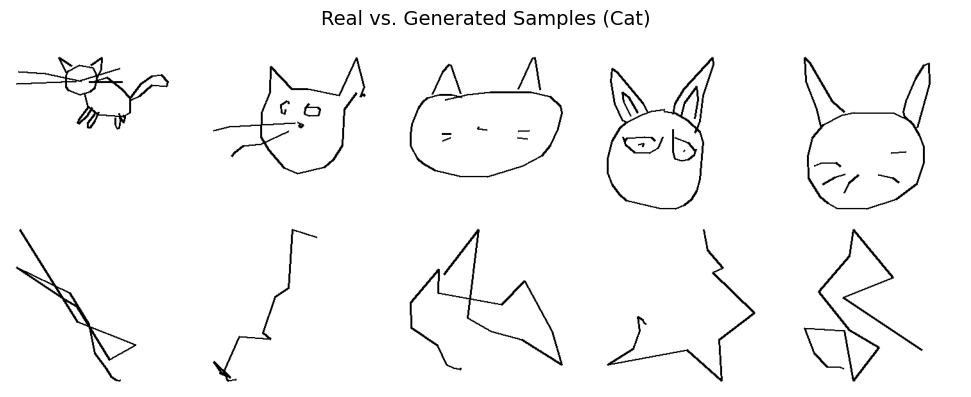

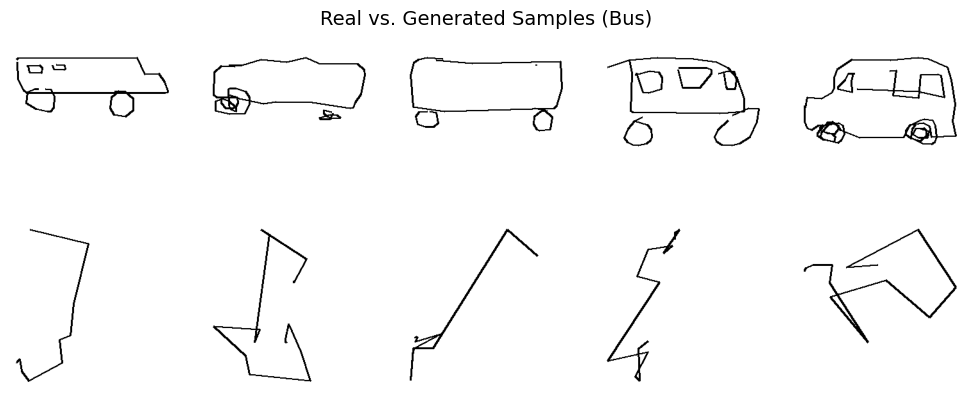

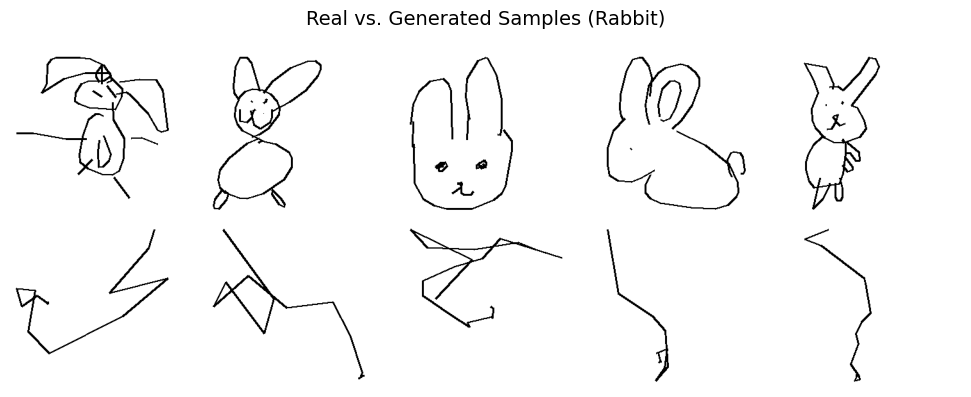

In [22]:
import os
from matplotlib import pyplot as plt


def plot_real_vs_fake(real_dir, fake_dir, count=5, title="Category"):
    real_images = sorted([f"{real_dir}/{f}" for f in os.listdir(real_dir) if f.endswith(".png")])[:count]
    fake_images = sorted([f"{fake_dir}/{f}" for f in os.listdir(fake_dir) if f.endswith(".png")])[:count]

    plt.figure(figsize=(count * 2, 4))
    for i in range(count):
        # Real
        plt.subplot(2, count, i + 1)
        img = Image.open(real_images[i])
        # plt.title("gercek")
        plt.imshow(img)
        plt.axis("off")
        if i == 0:
            plt.ylabel("Real", fontsize=12)

        # Fake
        plt.subplot(2, count, count + i + 1)
        img = Image.open(fake_images[i])
        # plt.title("fake")
        plt.imshow(img)
        plt.axis("off")
        if i == 0:
            plt.ylabel("Fake", fontsize=12)

    plt.suptitle(f"Real vs. Generated Samples ({title})", fontsize=14)
    plt.tight_layout()
    plt.show()


plot_real_vs_fake("real/cat", "fake/cat", title="Cat")
plot_real_vs_fake("real/bus", "fake/bus", title="Bus")
plot_real_vs_fake("real/rabbit", "fake/rabbit", title="Rabbit")
